In [1]:
!nvidia-smi


Mon Dec 15 15:26:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Step 1 — Install YOLOv8

In [2]:
!pip -q install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.7 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")          # small + fast
model.predict("https://ultralytics.com/images/bus.jpg", save=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 90.3ms
Speed: 13.3ms preprocess, 90.3ms inference, 52.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

##Step 2 — Download a “practice-sized” COCO set

In [4]:
!mkdir -p coco
!wget -q http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip -d coco

!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d coco


##Install tools for COCO conversion

In [5]:
!pip -q install pycocotools tqdm


##Convert COCO → YOLO format for only your classes

In [6]:
import os, shutil
from pycocotools.coco import COCO
from tqdm import tqdm

# ====== SETTINGS (change these if you want) ======
TARGET_CLASSES = ["person", "car"]   # <-- choose your topics here
MAX_IMAGES = 800                    # <-- keep small for practice
# ================================================

ANN = "coco/annotations/instances_val2017.json"
IMG_DIR = "coco/val2017"

OUT = "my_coco_subset"
images_out = os.path.join(OUT, "images")
labels_out = os.path.join(OUT, "labels")

# Clean output folder
if os.path.exists(OUT):
    shutil.rmtree(OUT)
os.makedirs(images_out, exist_ok=True)
os.makedirs(labels_out, exist_ok=True)

coco = COCO(ANN)

# COCO category ids for your chosen classes
cat_ids = coco.getCatIds(catNms=TARGET_CLASSES)
cat_id_to_yolo = {cid: i for i, cid in enumerate(cat_ids)}

# all image ids that contain at least one of these categories
img_ids = coco.getImgIds(catIds=cat_ids)
img_ids = img_ids[:MAX_IMAGES]

for img_id in tqdm(img_ids):
    img = coco.loadImgs(img_id)[0]
    w, h = img["width"], img["height"]
    file_name = img["file_name"]

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)
    if len(anns) == 0:
        continue

    # copy image
    src = os.path.join(IMG_DIR, file_name)
    dst = os.path.join(images_out, file_name)
    shutil.copy(src, dst)

    # write yolo labels
    label_path = os.path.join(labels_out, file_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        for a in anns:
            # COCO bbox = [x_min, y_min, width, height]
            x, y, bw, bh = a["bbox"]

            # convert to YOLO normalized format: x_center, y_center, w, h
            xc = (x + bw/2) / w
            yc = (y + bh/2) / h
            bw /= w
            bh /= h

            cls = cat_id_to_yolo[a["category_id"]]
            f.write(f"{cls} {xc} {yc} {bw} {bh}\n")

print("Done! Dataset at:", OUT)
print("Classes:", TARGET_CLASSES)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


100%|██████████| 359/359 [00:00<00:00, 1880.58it/s]

Done! Dataset at: my_coco_subset
Classes: ['person', 'car']


##Split into train/val folders

In [7]:
import os, random, shutil

OUT = "my_coco_subset"
train_dir = f"{OUT}/train"
val_dir   = f"{OUT}/val"

for p in [train_dir, val_dir]:
    os.makedirs(f"{p}/images", exist_ok=True)
    os.makedirs(f"{p}/labels", exist_ok=True)

all_imgs = sorted(os.listdir(f"{OUT}/images"))
random.shuffle(all_imgs)

split = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split]
val_imgs = all_imgs[split:]

def move_files(img_list, split_dir):
    for img in img_list:
        lbl = img.replace(".jpg", ".txt")
        shutil.move(f"{OUT}/images/{img}", f"{split_dir}/images/{img}")
        shutil.move(f"{OUT}/labels/{lbl}", f"{split_dir}/labels/{lbl}")

move_files(train_imgs, train_dir)
move_files(val_imgs, val_dir)

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))


Train images: 287
Val images: 72


##Create data.yaml

In [8]:
classes = ["person", "car"]  # MUST match TARGET_CLASSES order

yaml_text = f"""
path: my_coco_subset
train: train/images
val: val/images

names:
"""

for i, name in enumerate(classes):
    yaml_text += f"  {i}: {name}\n"

with open("data.yaml", "w") as f:
    f.write(yaml_text)

print(yaml_text)



path: my_coco_subset
train: train/images
val: val/images

names:
  0: person
  1: car



##Train YOLOv8 on your COCO subset

In [9]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # small model for beginners

model.train(
    data="data.yaml",
    epochs=10,
    imgsz=640,
    verbose=False
)



Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x786d4854f860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

##Test your trained model

In [10]:
import random, glob
from ultralytics import YOLO

best_model = YOLO("runs/detect/train/weights/best.pt")

img = random.choice(glob.glob("my_coco_subset/val/images/*.jpg"))
print("Testing on:", img)

best_model.predict(img, save=True, conf=0.25)


Testing on: my_coco_subset/val/images/000000274272.jpg

image 1/1 /content/my_coco_subset/val/images/000000274272.jpg: 480x640 2 cars, 39.3ms
Speed: 1.2ms preprocess, 39.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'car'}
 obb: None
 orig_img: array([[[213, 193, 175],
         [208, 189, 168],
         [217, 198, 177],
         ...,
         [119, 102,  99],
         [118, 103, 100],
         [120, 108, 104]],
 
        [[217, 197, 179],
         [203, 184, 163],
         [216, 197, 176],
         ...,
         [124, 108, 102],
         [126, 112, 106],
         [146, 134, 128]],
 
        [[209, 190, 169],
         [217, 198, 177],
         [212, 194, 171],
         ...,
         [125, 109, 103],
         [124, 110, 104],
         [138, 128, 121]],
 
        ...,
 
        [[107, 106, 102],
         [106, 105, 101],
         [106, 105, 101],
         ...,
         [ 72,  77,  80],
         [ 74,  79,  82],
         [ 71,  76,  77]],
 
        [[104, 100,  99],
         [110, 106, 105],
         [108, 107, 103],
         ...,
        

##**Display **

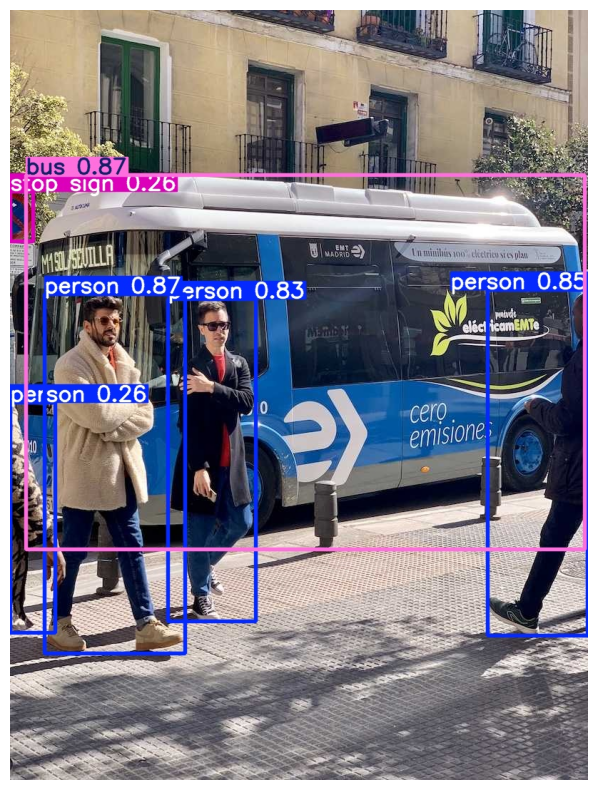

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

pred_img = sorted(glob.glob("runs/detect/predict/*.jpg"))[-1]
img = mpimg.imread(pred_img)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.show()
